In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mat
import pdcast as pdc
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
test = pd.read_csv("sales_train_validation.csv")
train = pd.read_csv("sales_train_evaluation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
calender = pd.read_csv("calendar.csv")
sample_sub = pd.read_csv("sample_submission.csv")

Downcasting the train_dataset

We have a huge dataset to work on, and before feeding this dataset into the model, we are going to "Melt" it which would the data fram would be converted from wide format to a long format. I have kept the id variables as id, item_id, dept_id, cat_id, store_id and state_id. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1969 days. Therefore the melted dataframe will be having 30490x1969 i.e. 60034810 rows.

In order to process to such huge dataset, we would need to reduce the memory usage.

In [ ]:
train_d = pdc.downcast(train)
test_d = pdc.downcast(test)
sell_prices_d = pdc.downcast(sell_prices)
calender_d  = pdc.downcast(calender)
sample_sub_d = pdc.downcast(sample_sub)

Checking the difference of original dataset and downcasted dataset

In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [ ]:
train_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: bool(5), category(5), object(1), uint16(47), uint8(1889)
memory usage: 58.3+ MB


Melting is Performed

In [ ]:
df = pd.melt(train_d, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

## So, this dataframe would be used for the further training of the LSTM as well as ARIMA model.

In [ ]:
df = pd.merge(df, calender_d, on='d', how='left')
df = pd.merge(df, sell_prices_d, on=['store_id','item_id','wm_yr_wk'], how='left')
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            object  
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             object  
 7   sold          object  
 8   date          object  
 9   wm_yr_wk      uint16  
 10  weekday       category
 11  wday          uint8   
 12  month         uint8   
 13  year          uint16  
 14  event_name_1  category
 15  event_type_1  category
 16  event_name_2  object  
 17  event_type_2  category
 18  snap_CA       bool    
 19  snap_TX       bool    
 20  snap_WI       bool    
 21  sell_price    float32 
dtypes: bool(3), category(9), float32(1), object(5), uint16(2), uint8(2)
memory usage: 3.9+ GB


# Exploratory Data Analysis -> for checking null values

In [ ]:
train_d.isnull().sum().sort_values(ascending = False)

id        0
d_1273    0
d_1301    0
d_1300    0
d_1299    0
         ..
d_639     0
d_638     0
d_637     0
d_636     0
d_1941    0
Length: 1947, dtype: int64

In [ ]:
sell_prices.isnull().sum().sort_values(ascending = False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [ ]:
calender_d.isnull().sum().sort_values(ascending = False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

So, I think the columns of calender_d should be dropped...

In [ ]:
import plotly.express as px

#for plotting the below graph its very much needed



group = df.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['sold'].sum().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'sold'},inplace=True)

group = group[group['sold']!=0]

#only the code above will remove the zero divivsion error in vscode jupyter extension not to be used in jupyter notebook.

fig = px.treemap(group, path=['USA','State', 'Store', 'Category', 'Department'], values='sold',
                  color='sold',
                  title='Sum of sales_function across whole USA/different States/Stores/Categories/Departments')
fig.update_layout(template='seaborn')
fig.show()

# Exploratory Data Analysis to prove that Seasonality Exists

In [ ]:
#function to plot sales_function accross different states

def sales_function(feat,param):
    dataframe_sales_function_temp = df.loc[df[feat] == param]
    dataframe_sales_function_temp['date'] = pd.to_datetime(dataframe_sales_function_temp['date'])
    dataframe_sales_function_temp =dataframe_sales_function_temp.groupby('date')['sold'].sum().reset_index()
    dataframe_sales_function_temp = dataframe_sales_function_temp.set_index('date')
    return dataframe_sales_function_temp

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



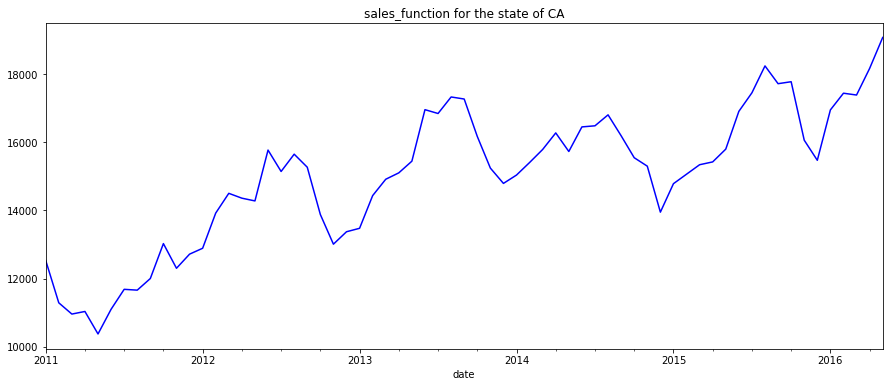

In [ ]:
CA = sales_function("state_id","CA") # create a dataframe for the state of california.
y_ca = CA['sold'].resample('MS').mean() # taking monthly average for the sales_function and then plotting them to prove seasonality.

#here, I have taken resample funtion with parameter 'MS' which signifies month start frequency. and .mean means taking the average of that sales_function.


y_ca.plot(figsize=(15, 6),color = "blue",title = ("sales_function for the state of CA"))
plt.ylabel = ("sales_function")
plt.show()

So, from the sbove graph we can conclude that there is an upward trend year on year. Whereas, I can see that there is always dip in sale prices on the start and end of the year which proves that seasonality does exists. So, we can see this trend in the states of Texas and Wisconsin.

In [ ]:
from itertools import cycle, islice
import statsmodels.api as sm
from pylab import rcParams
def decompose(y):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()

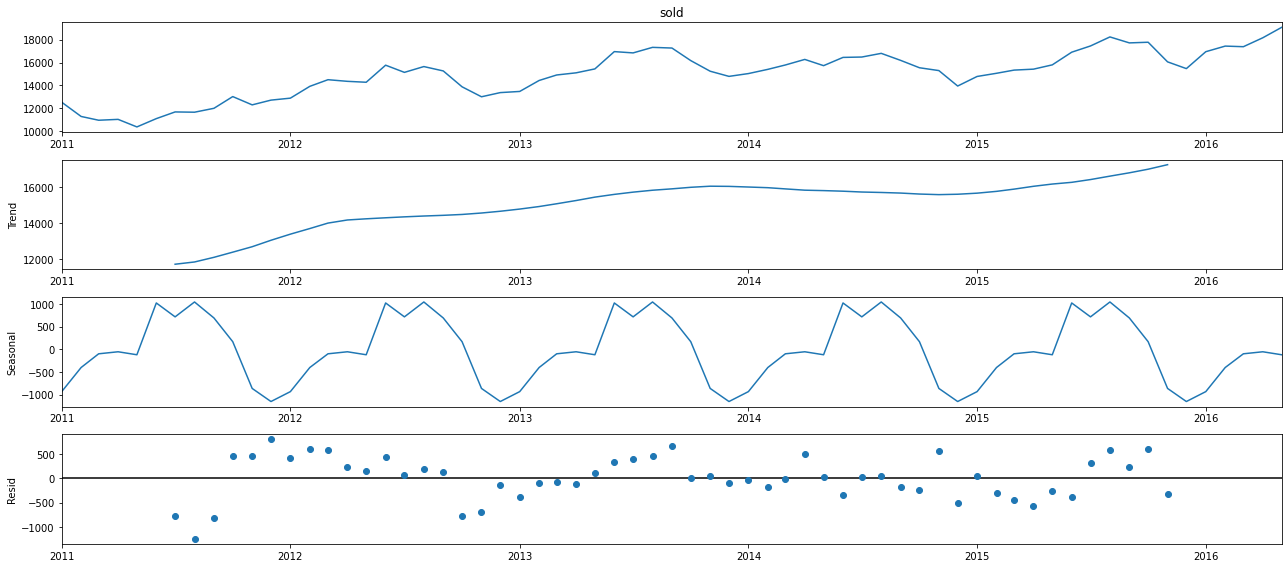

In [ ]:
decompose(y_ca)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



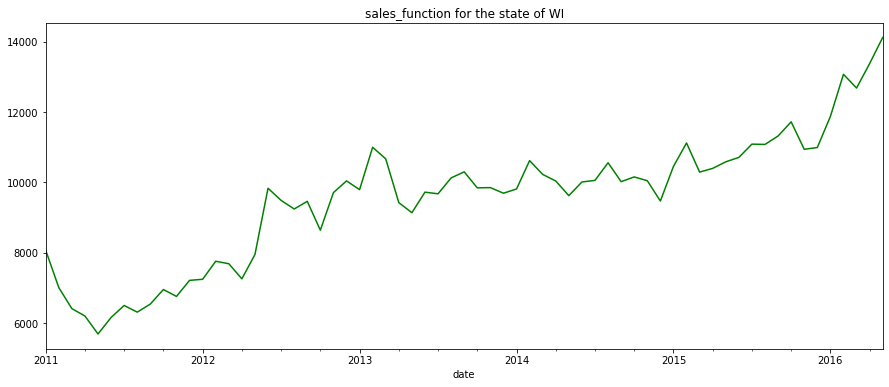

In [ ]:
WI = sales_function("state_id","WI")
y_wi = WI['sold'].resample('MS').mean()

y_wi.plot(figsize=(15, 6),color = "green",title = ("sales_function for the state of WI"))
plt.ylabel = ("sales_function")
plt.show()

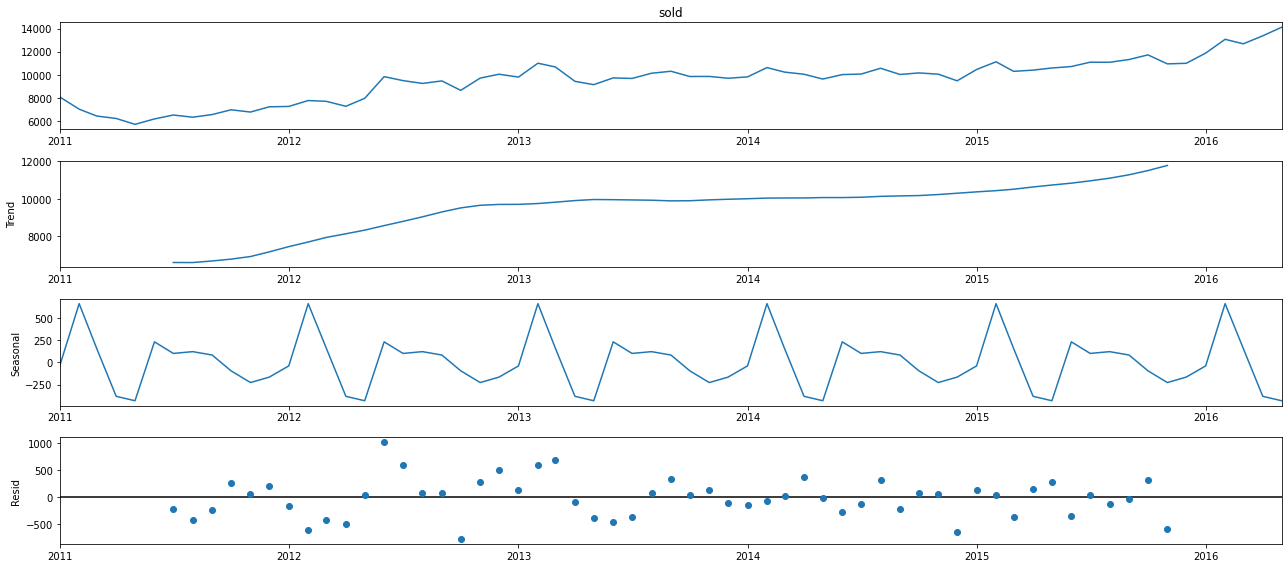

In [ ]:
decompose(y_wi)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



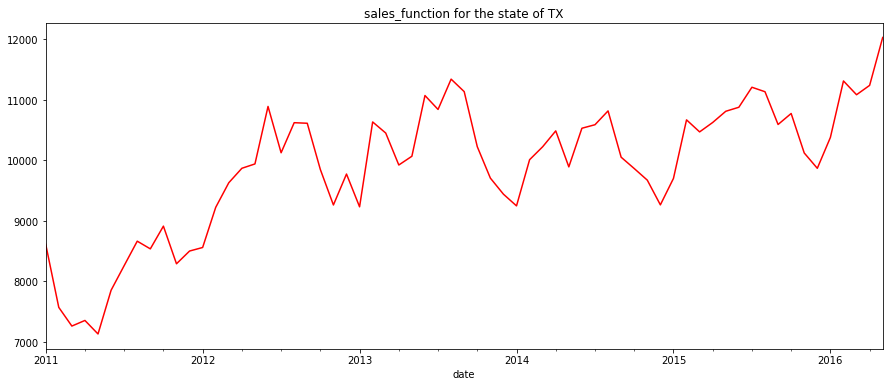

In [ ]:
TX = sales_function("state_id","TX")
y_tx = TX['sold'].resample('MS').mean()

y_tx.plot(figsize=(15, 6),color = "red",title = ("sales_function for the state of TX"))
plt.show()

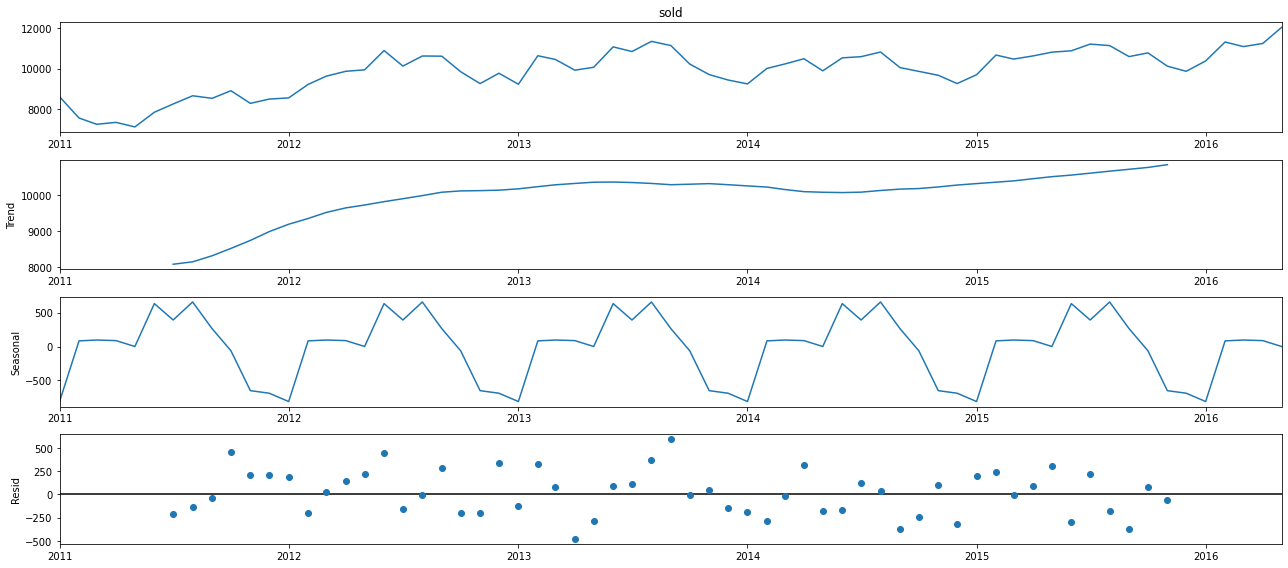

In [ ]:
decompose(y_tx)

In [ ]:
import gc
del CA,WI,TX
gc.collect()

34207

sales_function by category

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



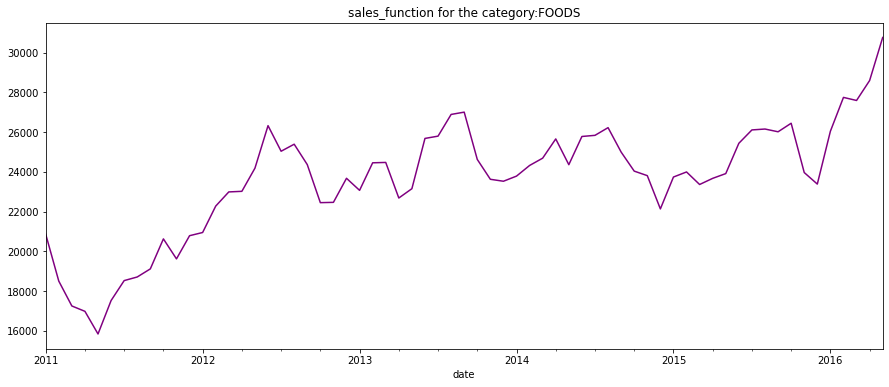

In [ ]:
foods = sales_function("cat_id","FOODS")
y_f = foods['sold'].resample('MS').mean()
y_f.plot(figsize=(15, 6),color = "purple",title = ("sales_function for the category:FOODS"))
plt.show()

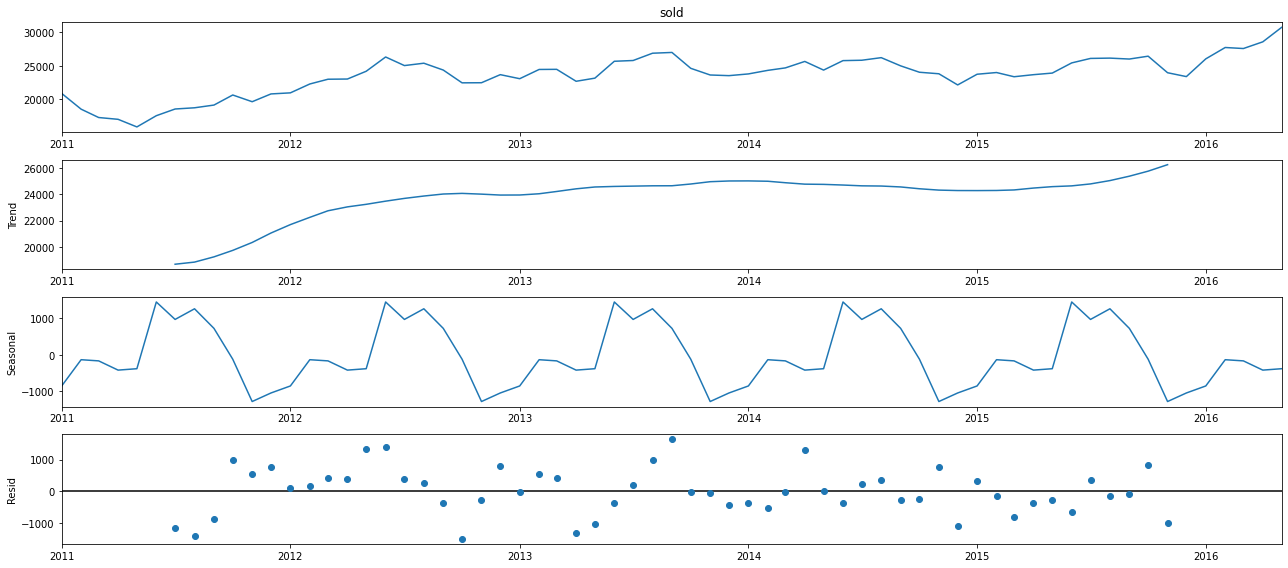

In [ ]:
decompose(y_f)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



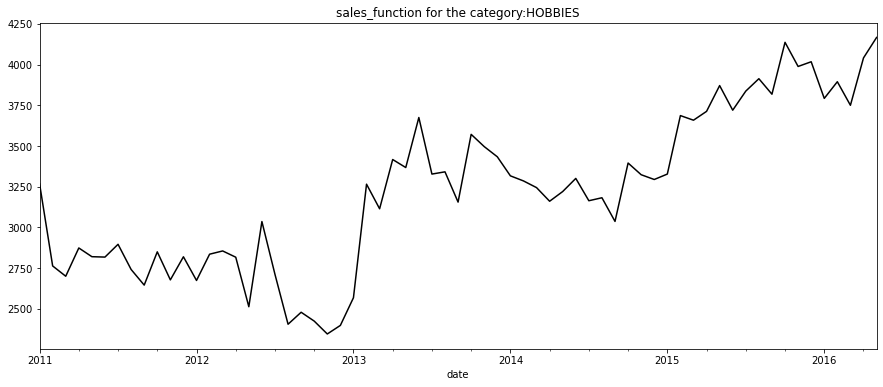

In [ ]:
hobbies = sales_function("cat_id","HOBBIES")
y_hb = hobbies['sold'].resample('MS').mean()

plt.ylabel = ("sales_function")
y_hb.plot(figsize=(15, 6),color = "black",title = ("sales_function for the category:HOBBIES"))
plt.show()

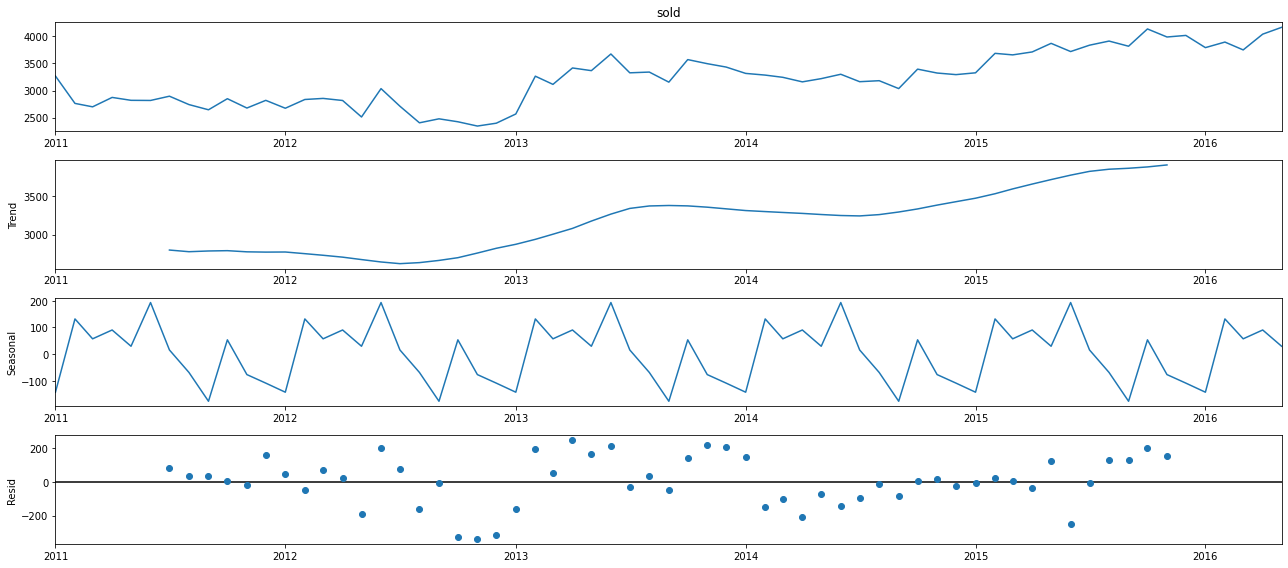

In [ ]:
decompose(y_hb)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



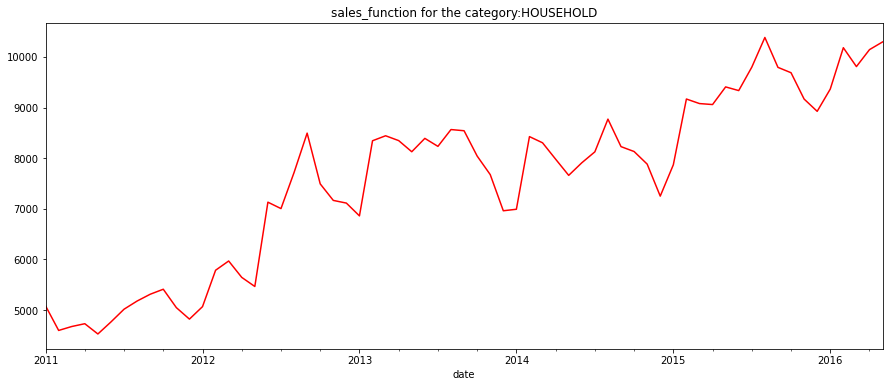

In [ ]:
household = sales_function("cat_id","HOUSEHOLD")
y_hh = household['sold'].resample('MS').mean()
y_hh.plot(figsize=(15, 6),color = "red",title = ("sales_function for the category:HOUSEHOLD"))
plt.show()

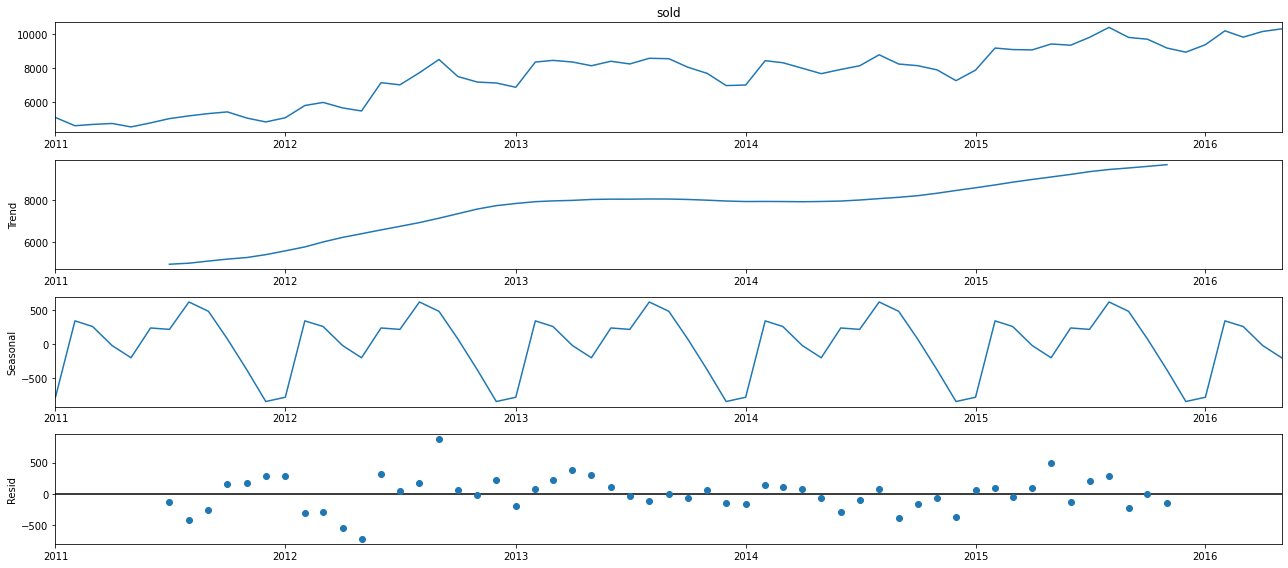

In [ ]:
decompose(y_hh)

In [ ]:
del foods,hobbies,household,y_f,y_hb,y_hh
gc.collect()

33993

# sales_function by store

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



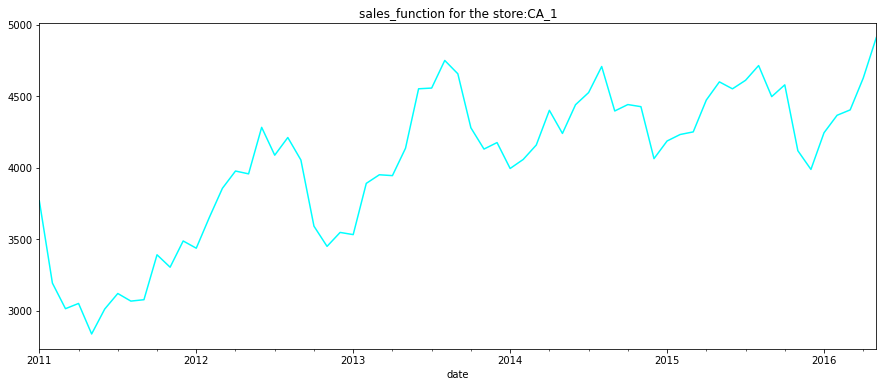

In [ ]:
CA_1 = sales_function("store_id","CA_1")
y_CA1 = CA_1['sold'].resample('MS').mean()

y_CA1.plot(figsize=(15, 6),color = "cyan",title = ("sales_function for the store:CA_1"))
plt.show()

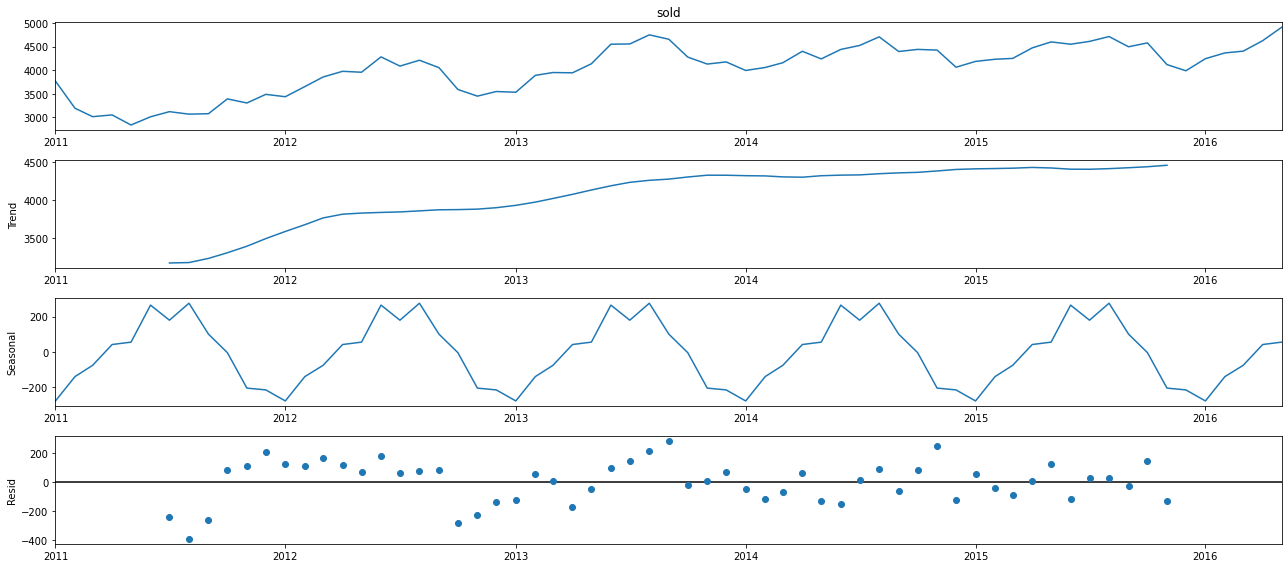

In [ ]:
decompose(y_CA1)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



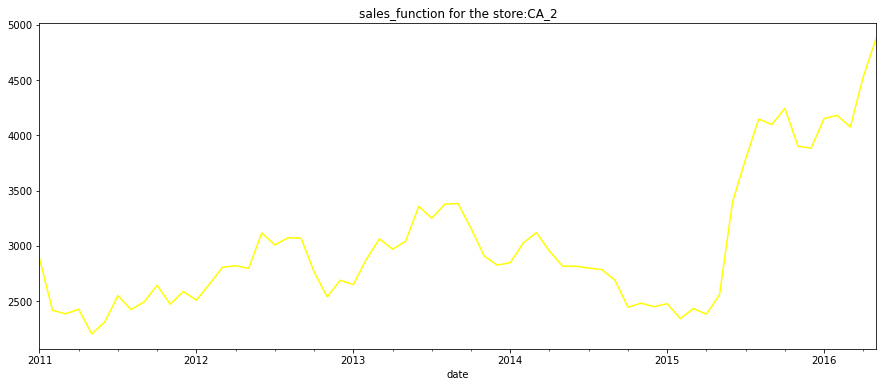

In [ ]:
CA_2 = sales_function("store_id","CA_2")
y_CA2 = CA_2['sold'].resample('MS').mean()

y_CA2.plot(figsize=(15, 6),color = "yellow",title = ("sales_function for the store:CA_2"))
plt.show()

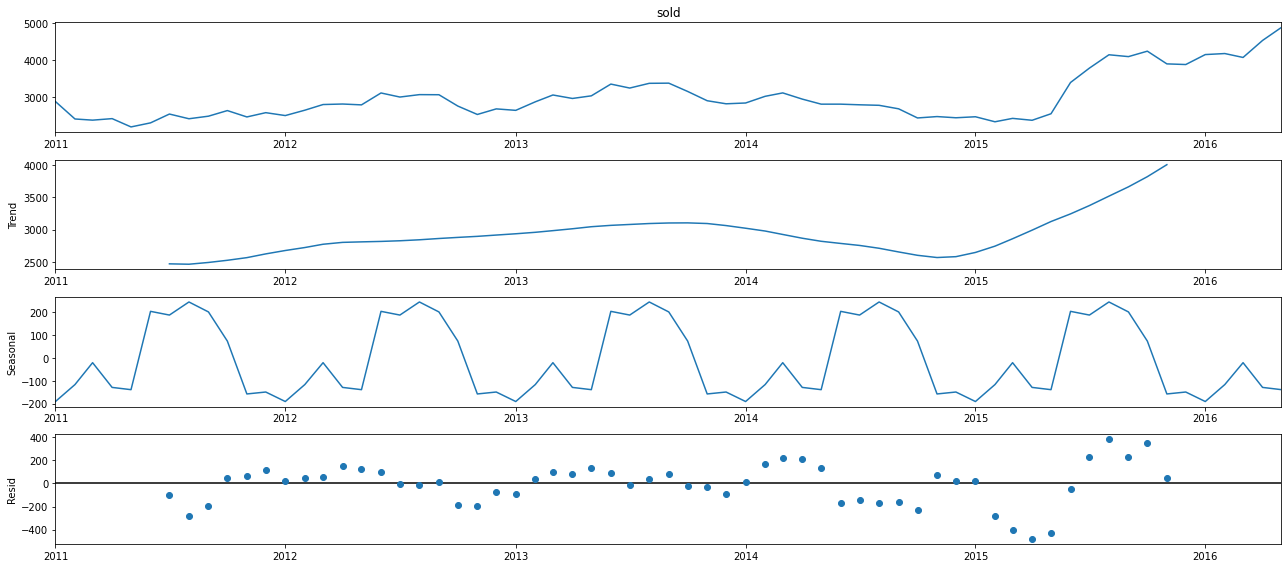

In [ ]:
decompose(y_CA2)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



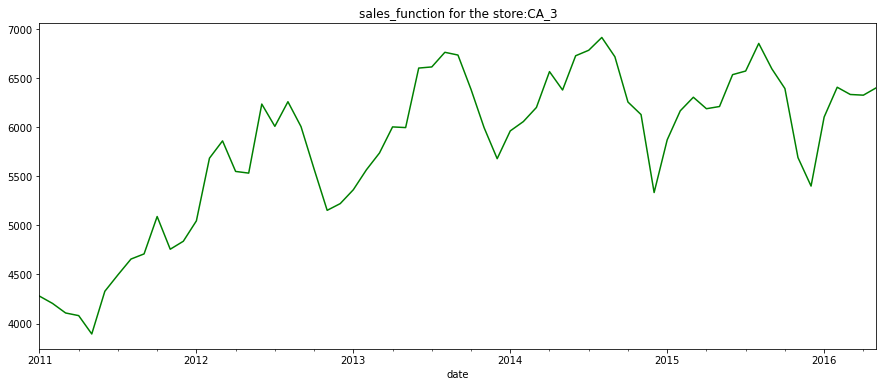

In [ ]:
CA_3 = sales_function("store_id","CA_3")
y_CA3 = CA_3['sold'].resample('MS').mean()

y_CA3.plot(figsize=(15, 6),color = "green",title = "sales_function for the store:CA_3")
plt.show()

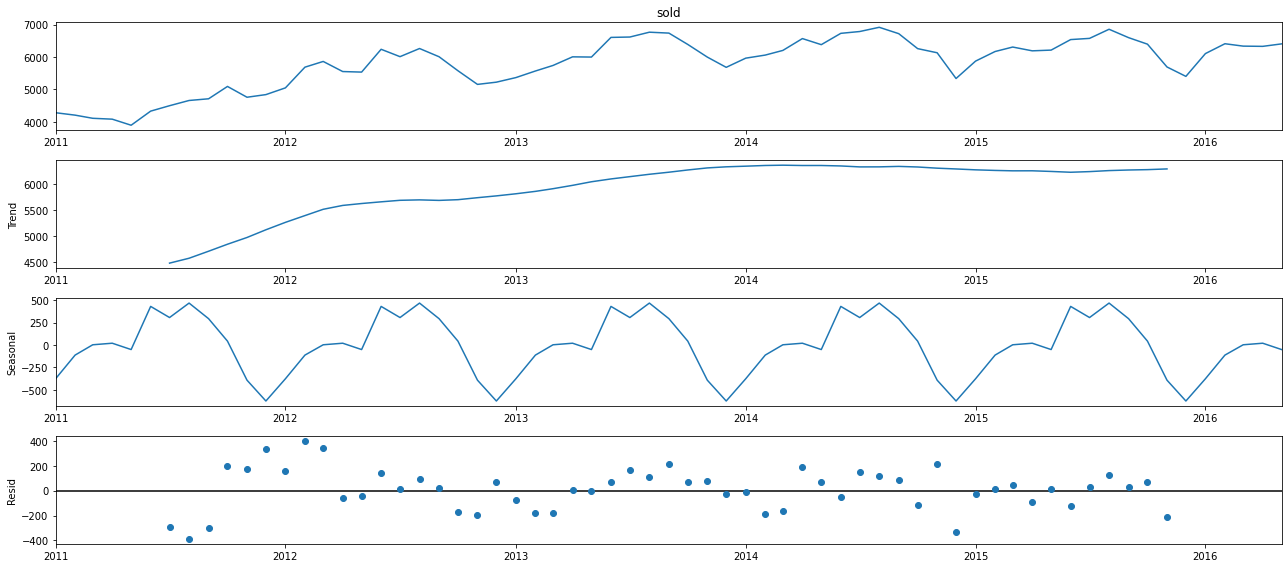

In [ ]:
decompose(y_CA3)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



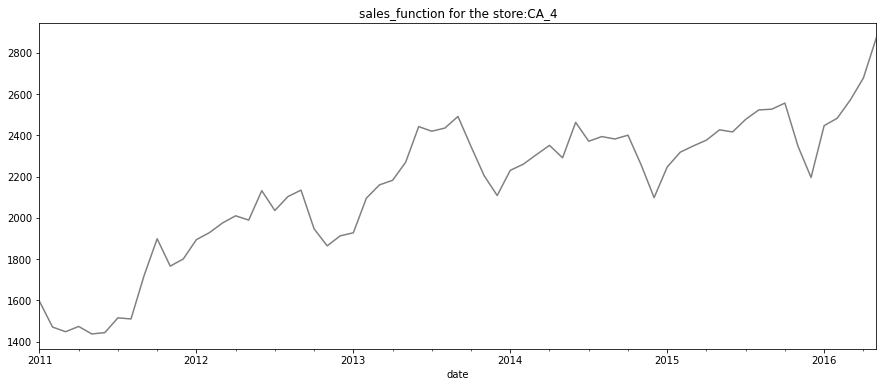

In [ ]:
CA_4 = sales_function("store_id","CA_4")
y_CA4 = CA_4['sold'].resample('MS').mean()

y_CA4.plot(figsize=(15, 6),color = "grey",title = ("sales_function for the store:CA_4"))
plt.show()

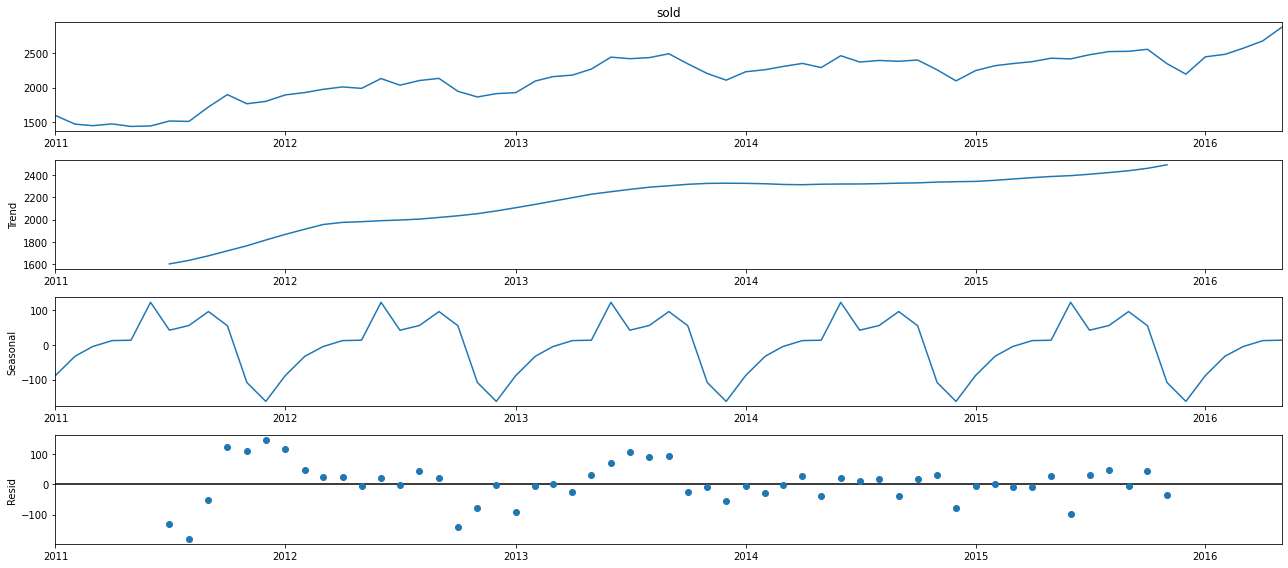

In [ ]:
decompose(y_CA4)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



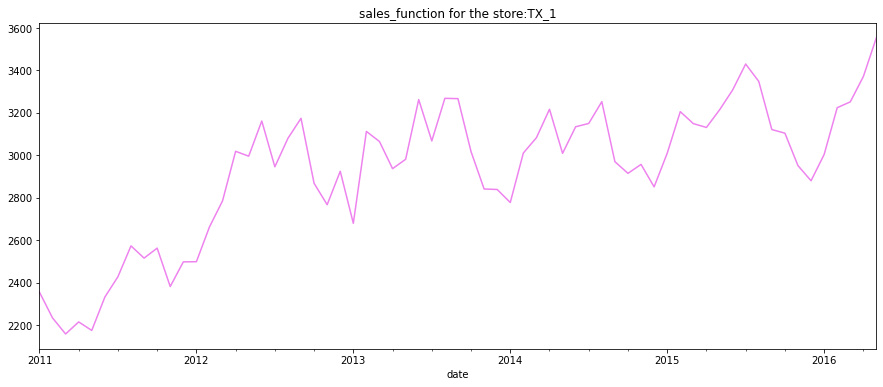

In [ ]:
TX_1 = sales_function("store_id","TX_1")
y_TX1 = TX_1['sold'].resample('MS').mean()

y_TX1.plot(figsize=(15, 6),color = "violet",title = ("sales_function for the store:TX_1"))
plt.show()

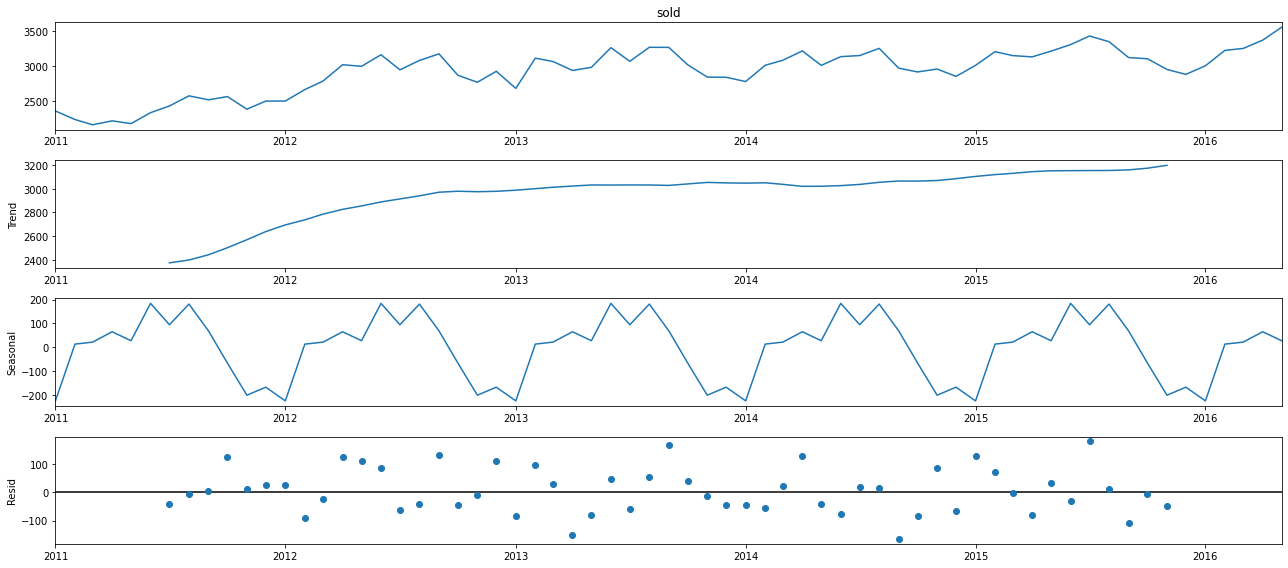

In [ ]:
decompose(y_TX1)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



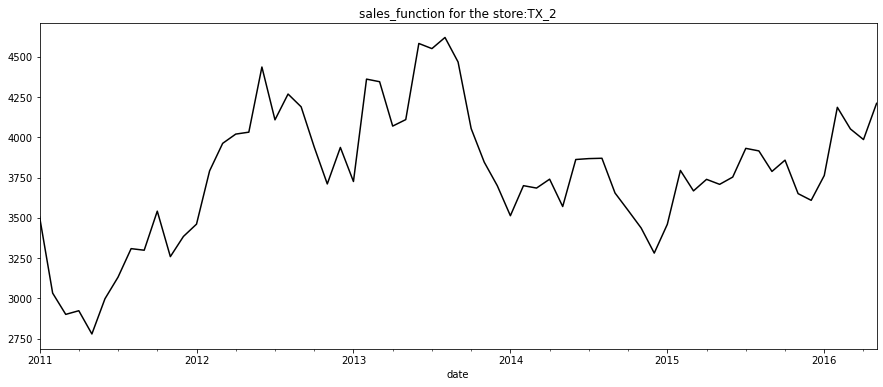

In [ ]:
TX_2 = sales_function("store_id","TX_2")
y_TX2 = TX_2['sold'].resample('MS').mean()
plt.ylabel = ("sales_function")
y_TX2.plot(figsize=(15, 6),color = "black",title = ("sales_function for the store:TX_2"))
plt.show()

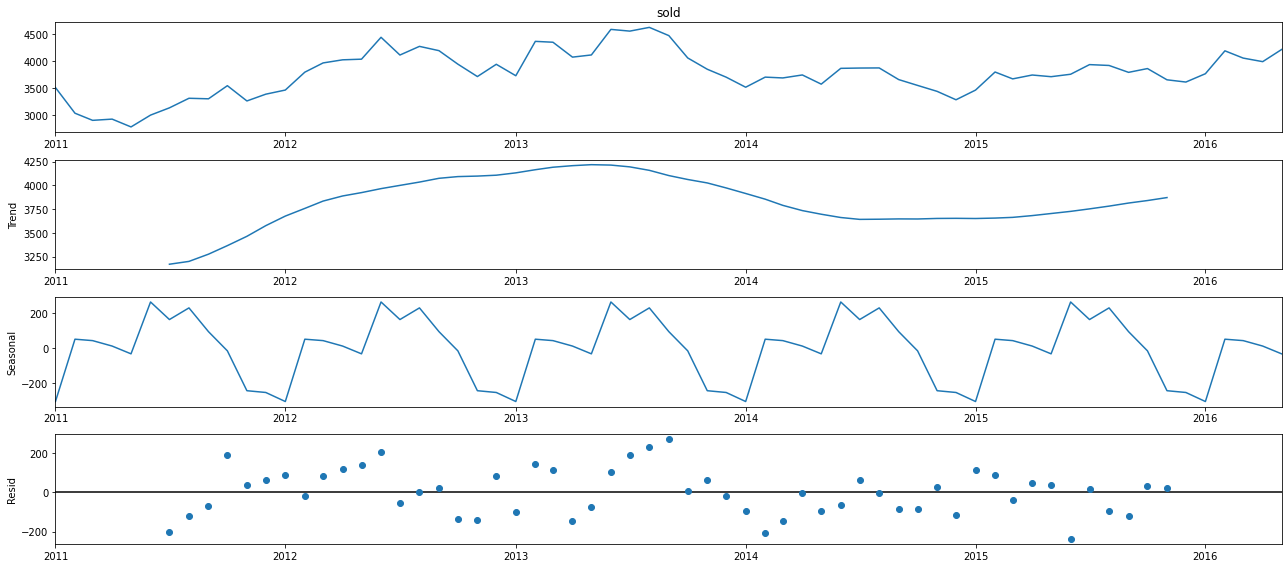

In [ ]:
decompose(y_TX2)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



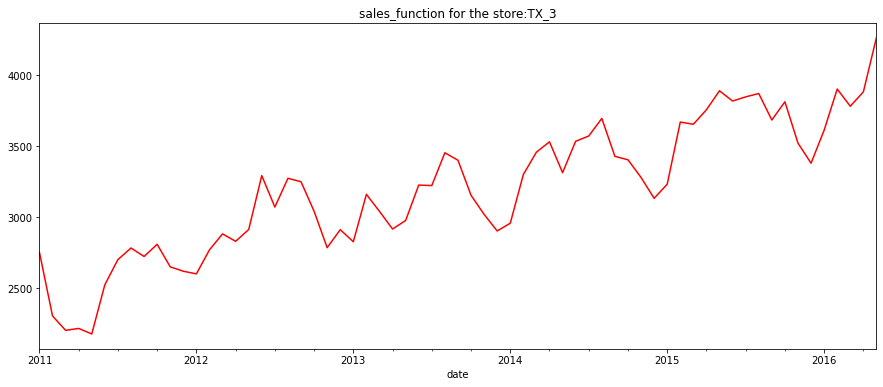

In [ ]:
TX_3 = sales_function("store_id","TX_3")
y_TX3 = TX_3['sold'].resample('MS').mean()

plt.ylabel = ("sales_function")
y_TX3.plot(figsize=(15, 6),color = "red",title = ("sales_function for the store:TX_3"))
plt.show()

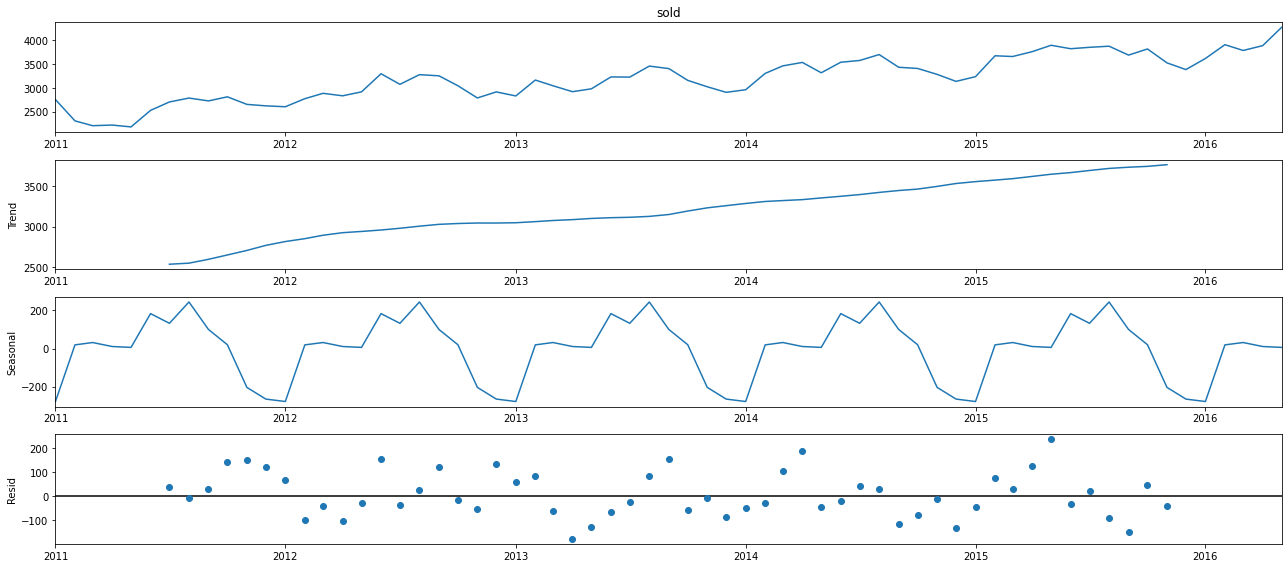

In [ ]:
decompose(y_TX3)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



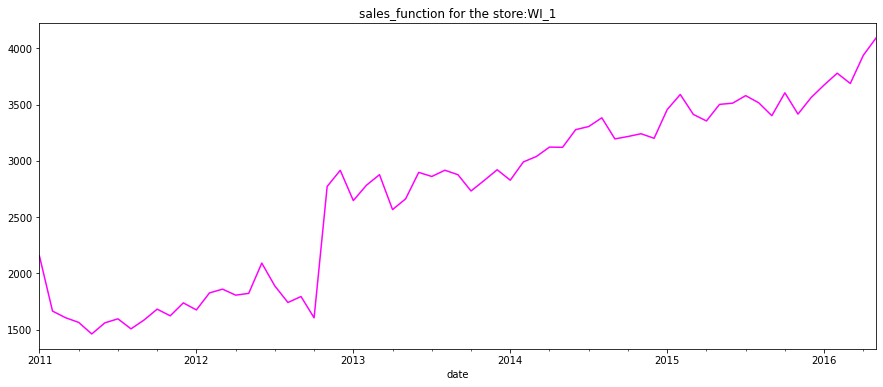

In [ ]:
WI_1 = sales_function("store_id","WI_1")
y_WI1 = WI_1['sold'].resample('MS').mean()

plt.ylabel = ("sales_function")
y_WI1.plot(figsize=(15, 6),color = "magenta",title = ("sales_function for the store:WI_1"))
plt.show()

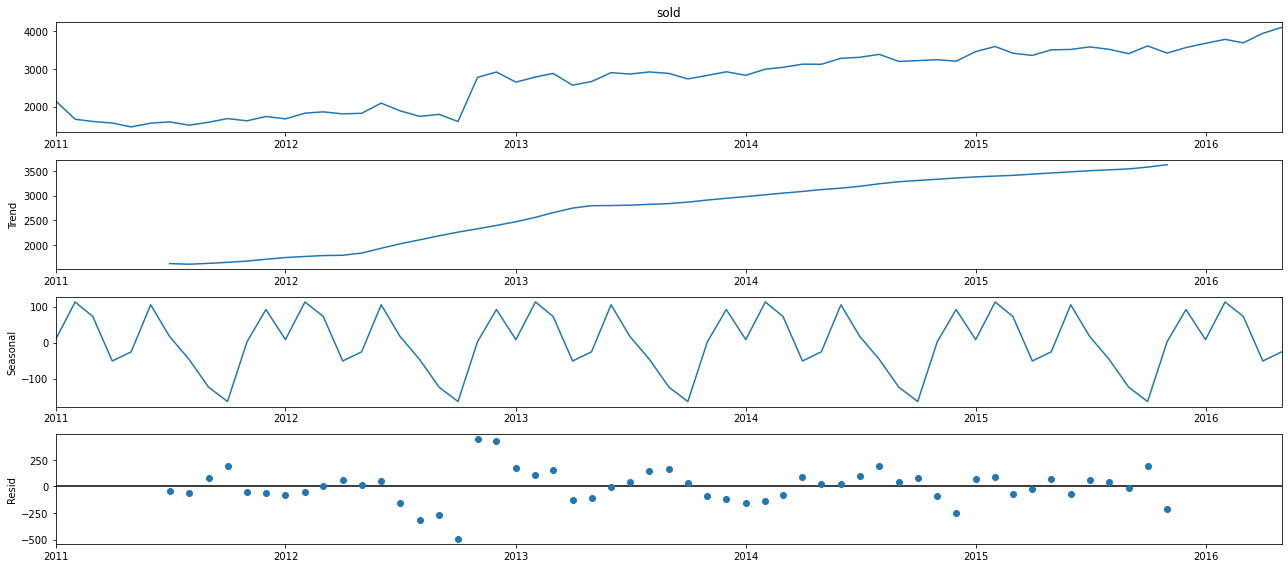

In [ ]:
decompose(y_WI1)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



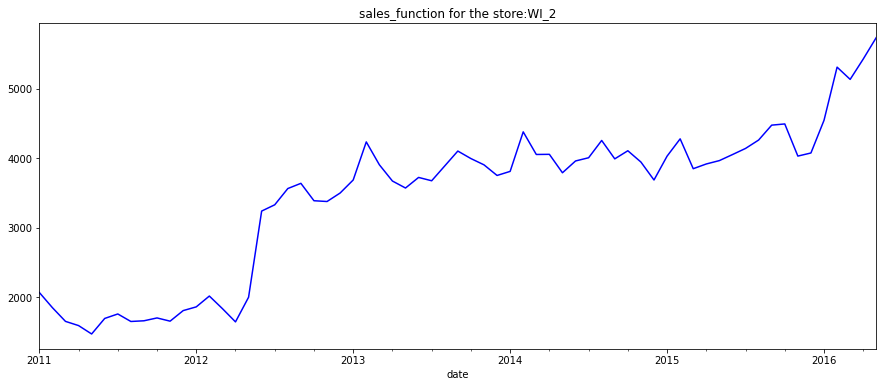

In [ ]:
WI_2= sales_function("store_id","WI_2")
y_WI2 = WI_2['sold'].resample('MS').mean()
plt.ylabel = ("sales_function")
y_WI2.plot(figsize=(15, 6),color = "blue",title = ("sales_function for the store:WI_2"))
plt.show()

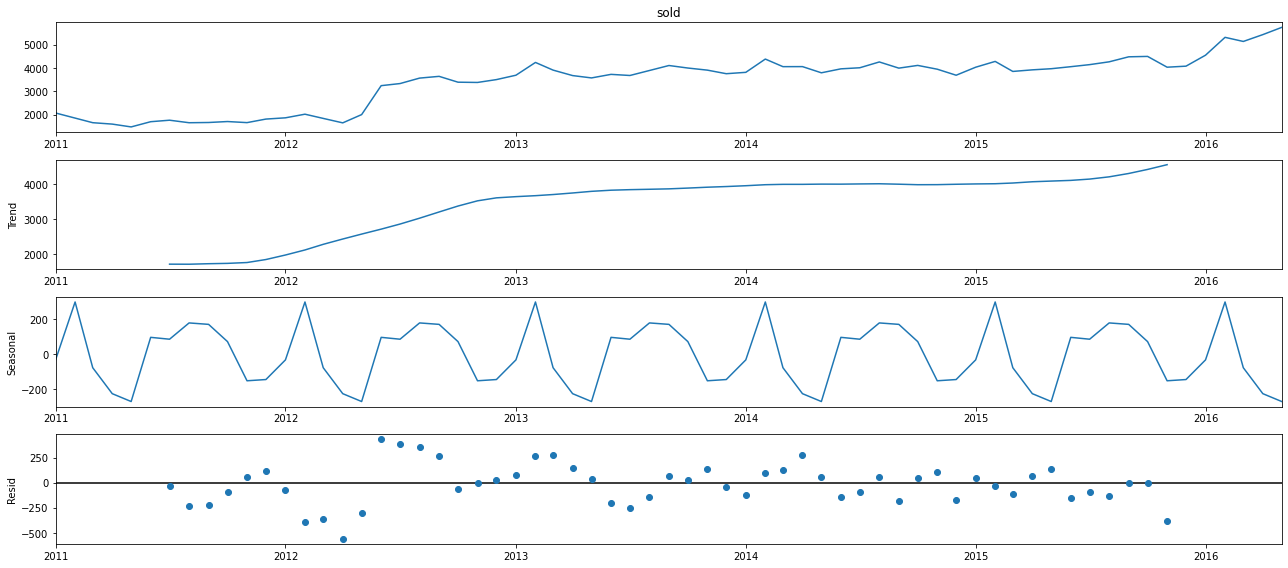

In [ ]:
decompose(y_WI2)

<ipython-input-13-aed4d4eebef6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



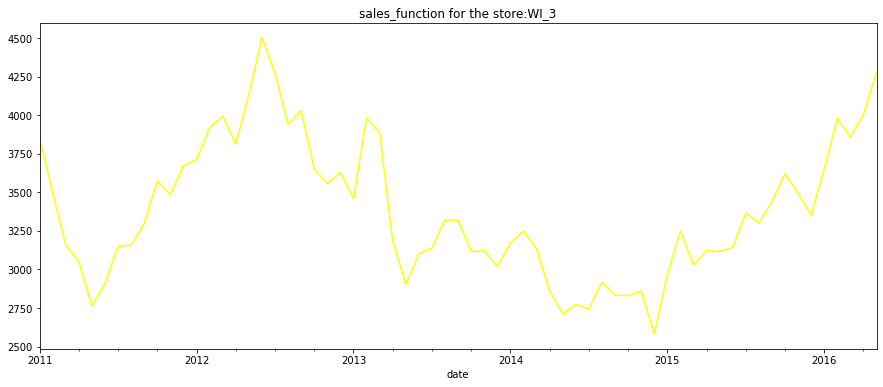

In [ ]:
WI_3= sales_function("store_id","WI_3")
y_WI3 = WI_3['sold'].resample('MS').mean()
plt.ylabel = ("sales_function")
y_WI3.plot(figsize=(15, 6),color = "yellow",title = ("sales_function for the store:WI_3"))
plt.show()

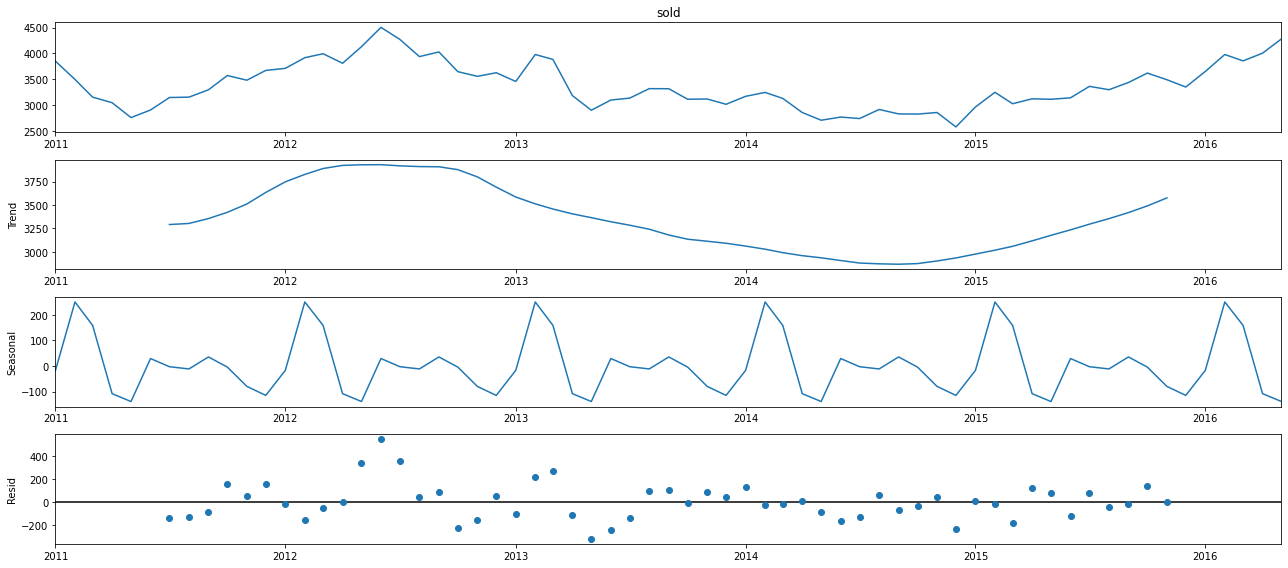

In [ ]:
decompose(y_WI3)

In [ ]:
del CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
gc.collect()

53742

# Ques 2 B Feature Engineering

In [ ]:
weather = pd.read_csv("weather.csv")
median_income = pd.read_csv("median_income.csv")

In [ ]:
#df1= df.copy()
import datetime as dt
df.date = pd.to_datetime(df.date)

In [ ]:
#restricting data to one year
df = df[df.date <= '2011-12-31']

In [ ]:
weather.DATE = pd.to_datetime(weather.DATE)

In [ ]:
weather = weather.drop_duplicates(subset=['Code','DATE'],keep='last')

> Imputing null values

In [ ]:
weather.isna().sum()

STATION         0
NAME            0
Code         1941
LATITUDE        0
LONGITUDE       0
ELEVATION       0
DATE            0
TAVG         9326
TMAX         5504
TMIN         5515
TOBS         7444
dtype: int64

In [ ]:
weather.TAVG = weather.TAVG.fillna((weather.TMAX+weather.TMIN)/2)

In [ ]:
weather.dropna(inplace=True)

In [ ]:
weather.head()

,STATION,NAME,Code,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
7265,USC00478919,WATERTOWN,WI_1,43.17424,-88.73633,251.5,2011-01-29,25.0,29.0,21.0,29.0
7266,USC00478919,WATERTOWN,WI_1,43.17424,-88.73633,251.5,2011-01-30,24.0,29.0,19.0,19.0
7267,USC00478919,WATERTOWN,WI_1,43.17424,-88.73633,251.5,2011-01-31,20.5,26.0,15.0,18.0
7268,USC00478919,WATERTOWN,WI_1,43.17424,-88.73633,251.5,2011-02-01,16.5,19.0,14.0,14.0
7269,USC00478919,WATERTOWN,WI_1,43.17424,-88.73633,251.5,2011-02-02,17.0,20.0,14.0,15.0


Merging the weather data with the evaluation dataset

Note: we added name column which merges each store_id to its corresponding name like CA_1 to long beach

In [ ]:
weather_merged = pd.merge (
    df, weather[['Code','DATE','TAVG']], how = "inner", left_on = ["store_id", "date" ],right_on = ['Code','DATE'],validate = 'm:1'
    
)

Merging the median income data to the data that we merged with weather

In [ ]:
median_income.head()

,Year,Label (Grouping),Code,Median income (dollars)
0,2016,ZCTA5 53091,WI_3,"56,484"
1,2016,ZCTA5 53094,WI_1,"55,983"
2,2016,ZCTA5 53097,WI_2,"105,538"
3,2016,ZCTA5 75032,TX_1,"91,431"
4,2016,ZCTA5 75048,TX_2,"85,771"


In [ ]:
final_merged = pd. merge (
    weather_merged, median_income , how = "left", left_on = ["store_id","year"],right_on=['Code','Year']
)

In [ ]:
final_merged.drop(columns=['Code_x','DATE','Year','Label (Grouping)','Code_y'],inplace=True)

In [ ]:
final_merged.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,TAVG,Median income (dollars)
0,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,False,False,False,NaN,52.0,85958.25
1,HOBBIES_1_002_CA_4_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,False,False,False,NaN,52.0,85958.25
2,HOBBIES_1_003_CA_4_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,False,False,False,NaN,52.0,85958.25
3,HOBBIES_1_004_CA_4_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_4,CA,d_1,1,2011-01-29,11101,...,NaN,NaN,NaN,NaN,False,False,False,4.34,52.0,85958.25
4,HOBBIES_1_005_CA_4_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,False,False,False,NaN,52.0,85958.25


Building LSTM model with external features 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
final_merged = sc.fit_transform(final_merged)

In [ ]:
timesteps=10
X_train = []
y_train = []
for i in range(timesteps, 365):
    X_train.append(final_merged[i-timesteps:i])
    y_train.append(final_merged[i][0:30490])

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size = 10)

# LSTM Model Training without External Parameters

In [ ]:
final_df = pd.read_csv("tableau_sales_function_train_evaluation_365_days.csv")#assigning the dataframe for this model's creation with the merged files.

In [ ]:
final_df = final_df.T

In [ ]:
final_df = final_df[6:]

In [ ]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_361,0,0,0,3,0,0,0,9,1,1,...,0,11,1,0,4,0,0,0,0,0
d_362,0,1,0,0,0,0,0,14,0,3,...,0,4,1,0,3,0,0,1,0,0
d_363,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,3,0,0,0,0,0
d_364,0,0,0,2,0,0,0,8,3,1,...,0,5,2,0,7,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
final_df = sc.fit_transform(final_df)

In [ ]:
timesteps=10
X_train = []
y_train = []
for i in range(timesteps, 365):
    X_train.append(final_df[i-timesteps:i])
    y_train.append(final_df[i][0:30490])

In [ ]:
X_train = np.array(X_train, dtype = 'float16')
y_train = np.array(y_train, dtype = 'float16')

In [ ]:
X_train.shape,y_train.shape

((355, 10, 30490), (355, 30490))

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units =64,input_shape = (np.array(X_train).shape[1], np.array(X_train).shape[2])))
model.add(tf.keras.layers.Dense(30490))

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                7822080   
                                                                 
 dense_1 (Dense)             (None, 30490)             1981850   
                                                                 
Total params: 9,803,930
Trainable params: 9,803,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
36/36 [==============================] - 5s 95ms/step - loss: 0.0179
Epoch 2/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0159
Epoch 3/10
36/36 [==============================] - 3s 84ms/step - loss: 0.0158
Epoch 4/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0158
Epoch 5/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0154
Epoch 6/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0150
Epoch 7/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0147
Epoch 8/10
36/36 [==============================] - 3s 82ms/step - loss: 0.0144
Epoch 9/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0143
Epoch 10/10
36/36 [==============================] - 3s 86ms/step - loss: 0.0141


# ARIMA without any external features


In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm


In [ ]:
gouped_by_cat_totals = train_d.groupby(['cat_id']).sum().T 

In [ ]:
cal_columns = ['date','d','month','year','wday','event_type_1','event_type_2']
calendar_selected = calender_d[cal_columns].set_index('d')
total_sales_function_OverCalendar = pd.concat([calendar_selected,gouped_by_cat_totals],axis=1,sort=False)
print(total_sales_function_OverCalendar['event_type_1'].unique())
print(total_sales_function_OverCalendar['event_type_2'].unique())
total_sales_function_OverCalendar.head()

[NaN, 'Sporting', 'Cultural', 'National', 'Religious']
Categories (4, object): ['Cultural', 'National', 'Religious', 'Sporting']
[NaN, 'Cultural', 'Religious']
Categories (2, object): ['Cultural', 'Religious']


,date,month,year,wday,event_type_1,event_type_2,FOODS,HOBBIES,HOUSEHOLD
d_1,2011-01-29,1,2011,1,NaN,NaN,22922.00000,3764.00000,5689.00000
d_2,2011-01-30,1,2011,2,NaN,NaN,22502.00000,3357.00000,5634.00000
d_3,2011-01-31,1,2011,3,NaN,NaN,17174.00000,2682.00000,3927.00000
d_4,2011-02-01,2,2011,4,NaN,NaN,18622.00000,2669.00000,3865.00000
d_5,2011-02-02,2,2011,5,NaN,NaN,14347.00000,1814.00000,2729.00000


Test Statistic                -2.34479
p-value                        0.15793
#Lags Used                    26.00000
No of Observesations Used   1942.00000
Critical Value (1%)           -3.43372
Critical Value (5%)           -2.86303
Critical Value (10%)          -2.56756
dtype: float64


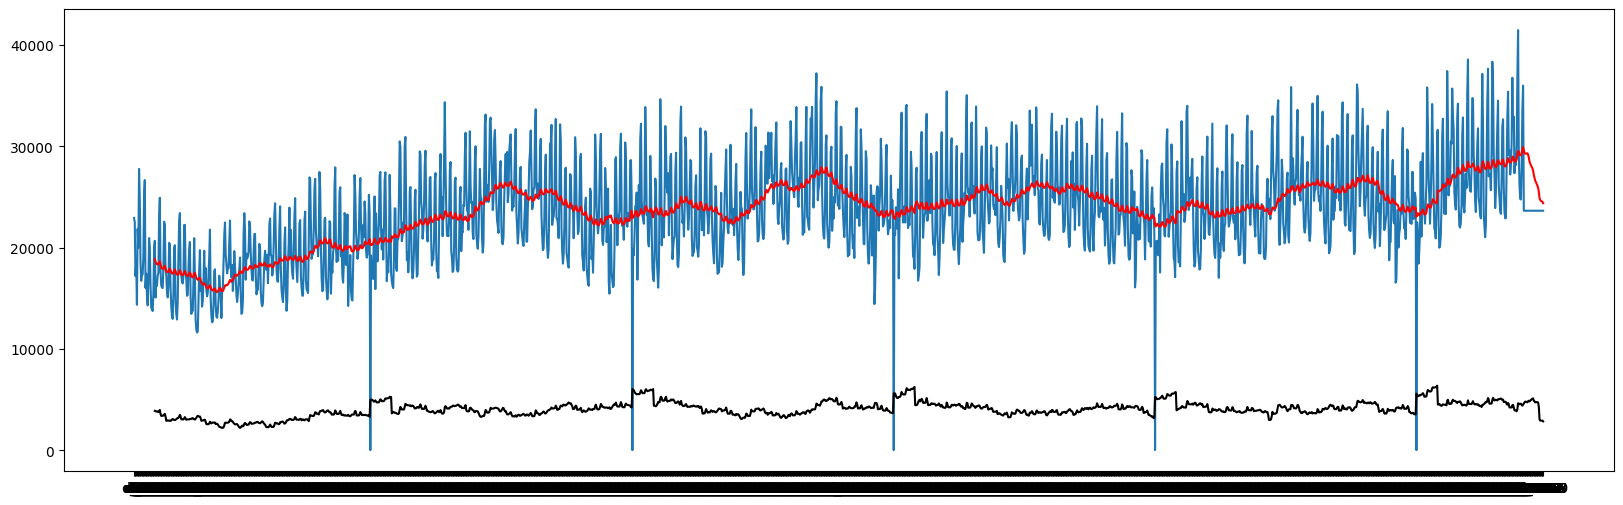

In [ ]:
#Making time series stationary

def test_stationarityDF(timeseries): # Dickey-Fuller (ADF) Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

food_series_df = total_sales_function_OverCalendar['FOODS']
food_series_df.fillna(food_series_df.mean(),inplace=True)
test_stationarityDF(food_series_df)

movingAverage = food_series_df.rolling(window=30).mean()
movingSTD = food_series_df.rolling(window=30).std()
plt.figure(figsize=(20,6))
plt.plot(food_series_df)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

We can observe that Test Statistic is not below the 1% of the Critical value. So,Series is not stationary.

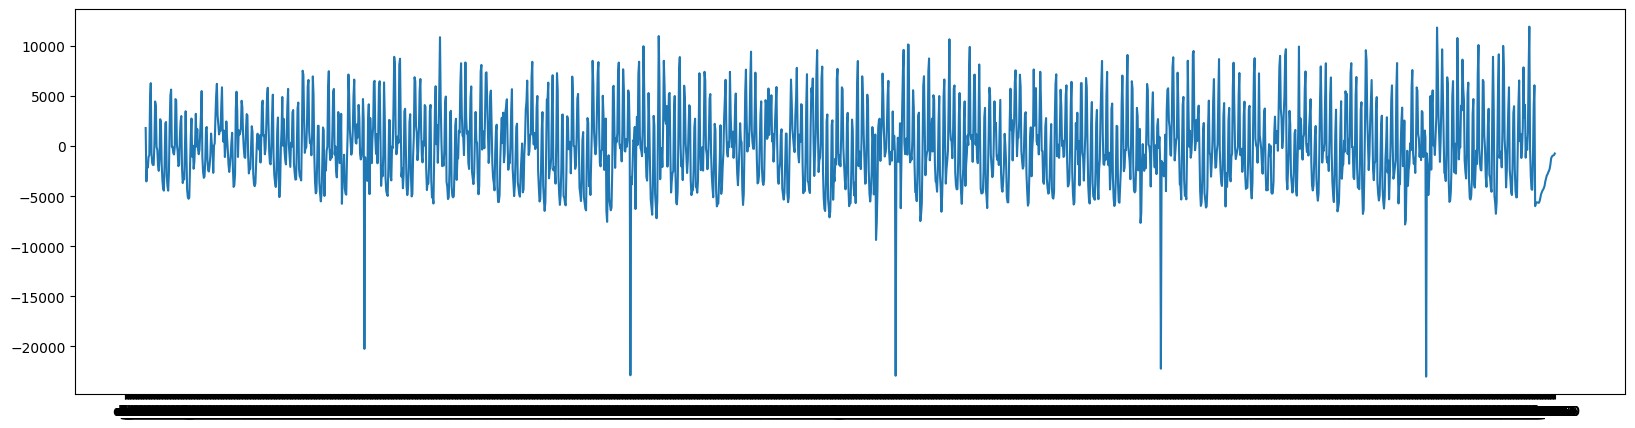

Test Statistic                -7.62850
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1942.00000
Critical Value (1%)           -3.43372
Critical Value (5%)           -2.86303
Critical Value (10%)          -2.56756
dtype: float64


In [ ]:
#Make stationary
food_derived = food_series_df-movingAverage
plt.figure(figsize=(20,5))
plt.plot(food_derived)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
food_derived.fillna(food_derived.mean(),inplace=True)
test_stationarityDF(food_derived)

In [ ]:
food_derived.info

<bound method Series.info of d_1         43.16409
d_2         43.16409
d_3         43.16409
d_4         43.16409
d_5         43.16409
             ...    
d_1965   -1053.60232
d_1966    -969.60749
d_1967    -930.87932
d_1968    -893.91783
d_1969    -743.65633
Name: FOODS, Length: 1969, dtype: float64>

We can observe that Test Statistic is way less than 1% of critical value. So, we can conculde that the above Series is 99% stationary.

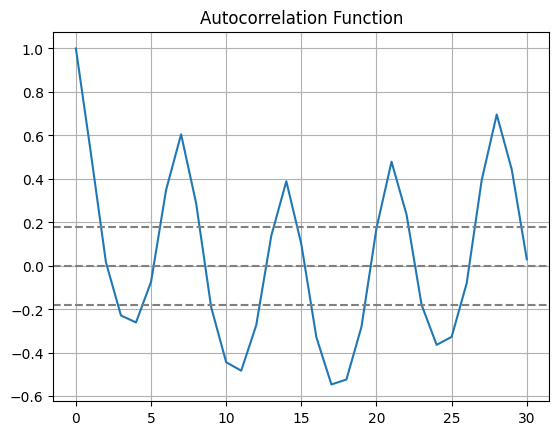

In [ ]:
plt.plot(np.arange(0,31,1),acf(food_derived,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(food_derived)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(food_derived)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

Here, the function cross upper confident value between 1 and 2. Hence chose 2 as p for ARIMA

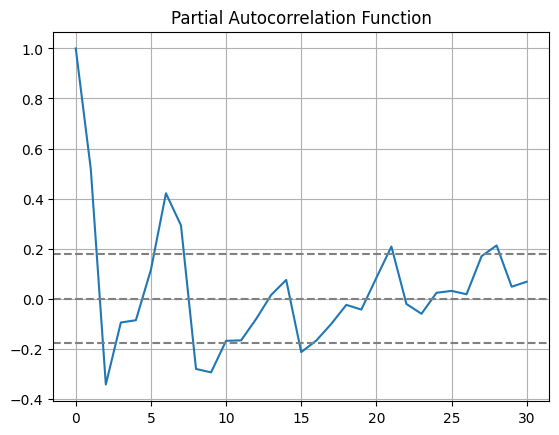

In [ ]:
plt.plot(np.arange(0,31,1),pacf(food_derived,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(food_derived)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(food_derived)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

Partial Autocorrelation function drop to 0 when value is between 1 and 2. choose 2 as q value

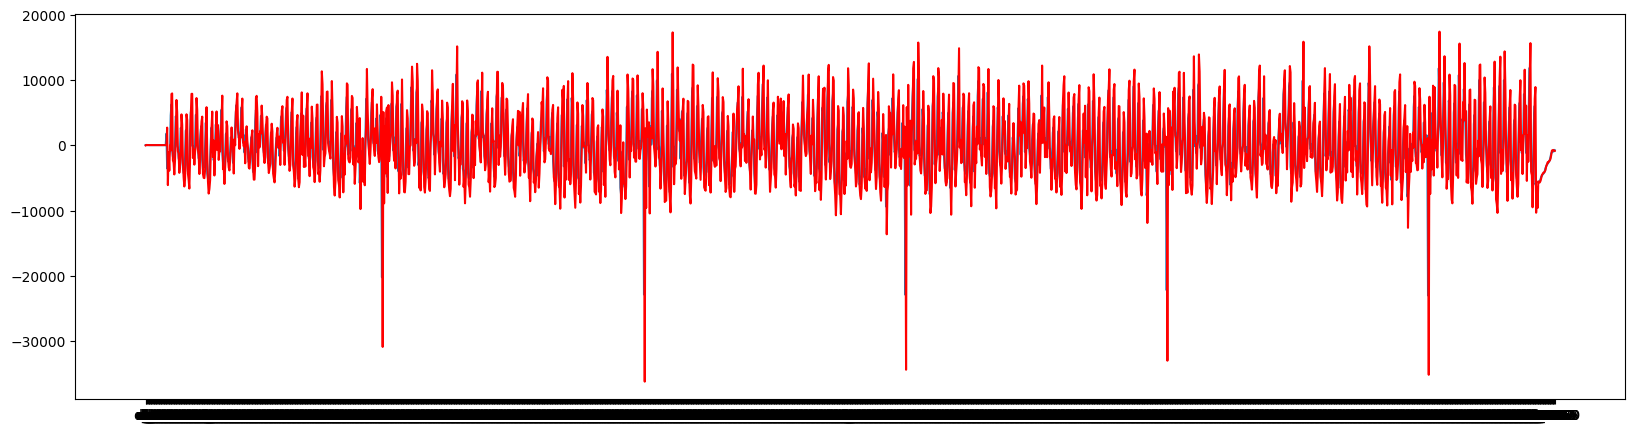

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = sm.tsa.arima.ARIMA(food_derived,order=(2,2,0))
model_ARIMA = model.fit()
plt.figure(figsize=(20,5))
plt.plot(food_derived)
plt.plot(model_ARIMA.fittedvalues,color='red')
plt.show()

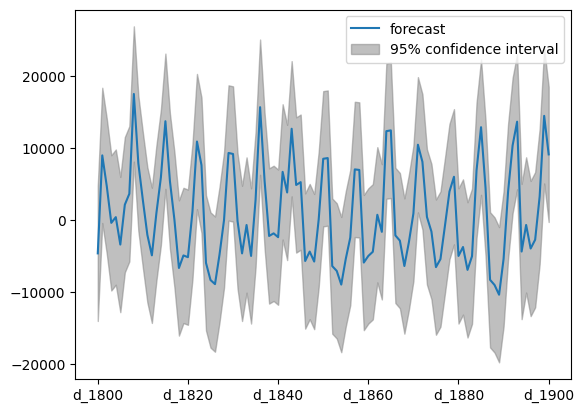

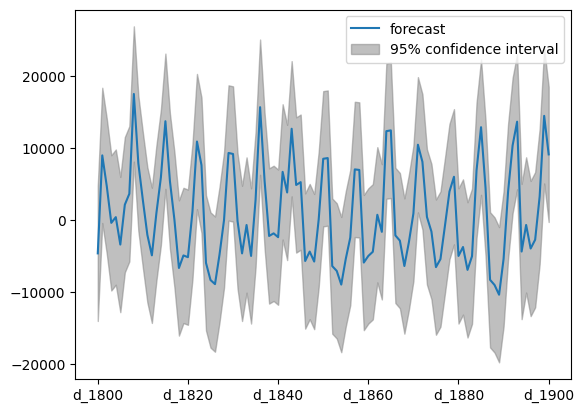

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_ARIMA, 'd_1800','d_1900',dynamic=False)

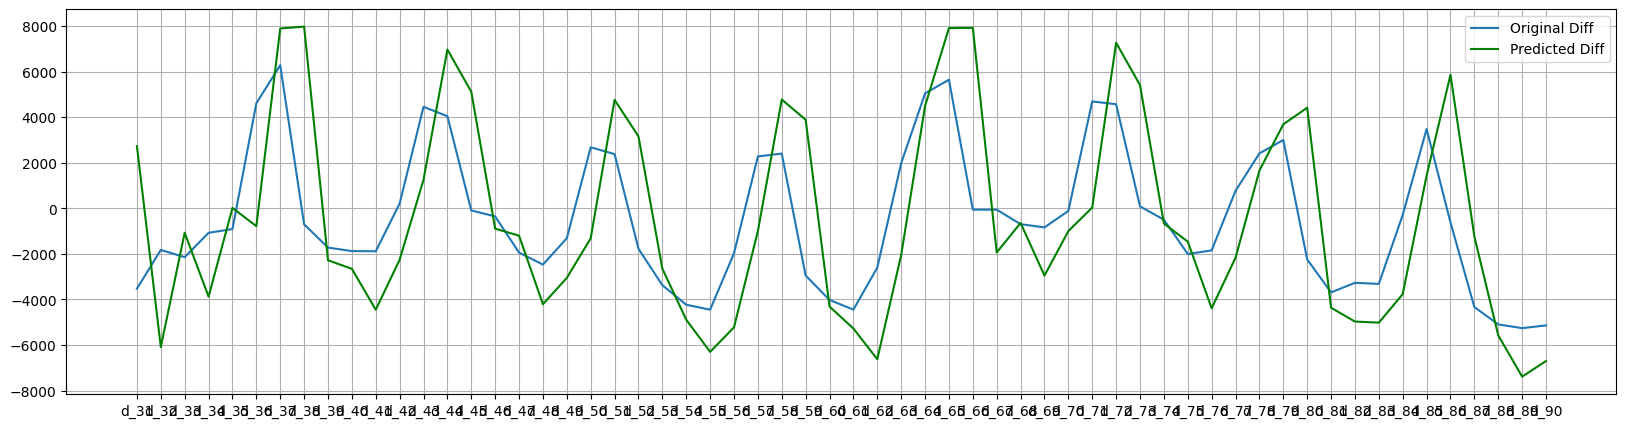

In [ ]:

plt.figure(figsize=(20,5))
ori = plt.plot(food_derived.iloc[30:90],label='Original Diff')

shfited = pd.DataFrame({'predicShfited2':pd.Series(model_ARIMA.fittedvalues,copy=True),'day':food_derived.index[:1969]})
shfited = shfited.set_index('day')
pre = plt.plot(shfited['predicShfited2'].iloc[30:90],color='green',label='Predicted Diff')

plt.legend(loc='best')
plt.grid()
plt.show()

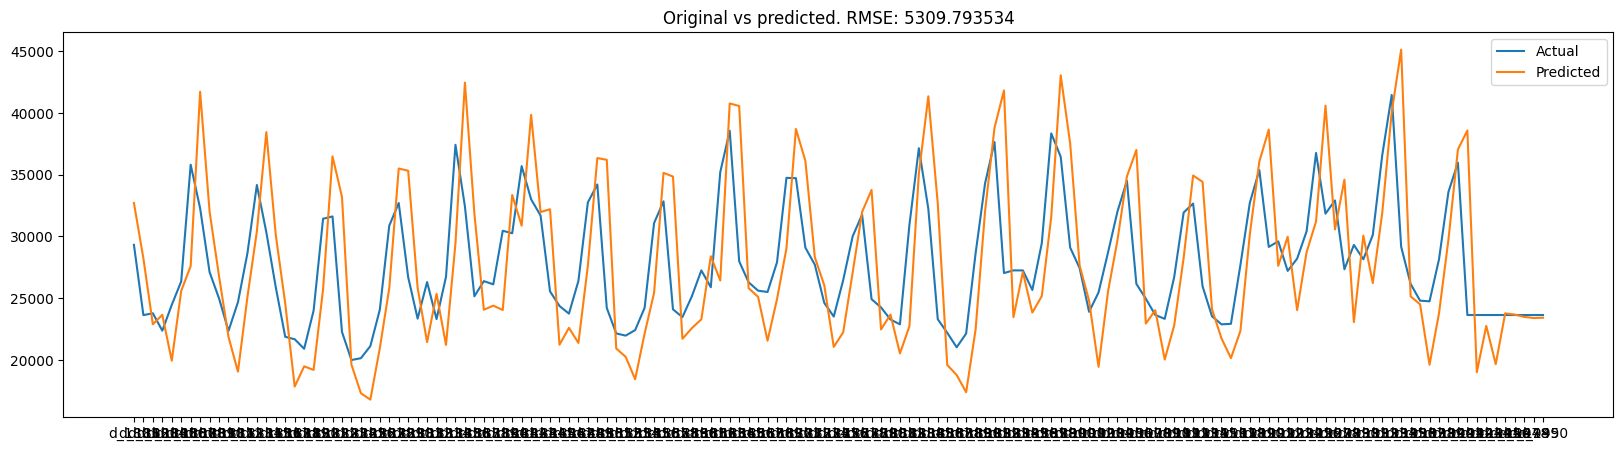

In [ ]:
predictions_ARIMA_final = pd.Series(food_series_df.at['d_2'],index=food_series_df.index)
shfited.loc['d_1'] = 0
shfited.loc['d_2'] = 0
movingAverage.fillna(0)
predictVsActual = pd.DataFrame({'actual':food_series_df,'diffMean':food_derived,
                                'predictDiffOri':shfited['predicShfited2'],
                                'predictDiff':shfited['predicShfited2'],
                                'base':movingAverage})
predictVsActual['predict'] = predictVsActual.loc[:,['predictDiff','base']].sum(axis=1)
predictVsActual['error'] = predictVsActual['actual'] - predictVsActual['predict']
plt.figure(figsize=(20,5))
plt.plot(predictVsActual['actual'].iloc[1800:1950],label='Actual')
plt.plot(predictVsActual['predict'].iloc[1800:1950],label='Predicted')

plt.legend(loc='best')
plt.title('Original vs predicted. RMSE: %4f'%np.sqrt(sum(predictVsActual['error']**2)/len(predictVsActual)))
plt.show()
